# Custom Script Contest – Urban Growth in Africa
---
Prepared by: _William Ray, Maxim Lamare, and Max Kampen; Sentinel Hub._

## Getting started with data

In this demonstration Jupyter Notebook, steps to access all the multi-temporal and multi-resolution data available for the contest will be detailed, along with basic processing examples.

## Available datasets

Data from the following satellite products are available for this contest. To jump directly to the section of interest, just click on one of the following products:

- Sentinel-1 [CARD4L](#Sentinel-1-CARD4L)

- Sentinel-1 [GRD](#Sentinel-1-GRD)

- Sentinel-2 [L1C](#Sentinel-2-L1C) & [L2A](#Sentinel-2-L2A)

- Landsat-8 [Collection 2](#Landsat-8-Collection-2) Level 1 & 2

- Airbus [SPOT 6/7](#AIRBUS-SPOT-6/7)

- Airbus [Pléiades](#AIRBUS-Pleiades)

- PlanetScope (coming soon)

- Maxar Worldview & GeoEye (coming soon)

## Configuration

Before acccessing the data, we will start by importing the necessary Python libraries (already configured in your EDC workspace), and generate credentials automatically to access the services.

In [1]:
# EDC libraries
from edc import setup_environment_variables
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
from xcube.core.gen2.combiner import CubesCombiner
from xcube.core.geom import mask_dataset_by_geometry

# Sentinel Hub
from sentinelhub import BBox, SentinelHubRequest, bbox_to_dimensions, DataCollection, MimeType, SHConfig, geometry

# Utilities
import IPython.display
from os import environ
import matplotlib.pyplot as plt
import datetime as dt

# Numerical computation
import xarray as xr
import numpy as np

### BYOC access points

Sentinel-1 CARD4L and the Very High Resolution collections are provided as pre-processed [BYOC](https://docs.sentinel-hub.com/api/latest/data/byoc/#accessing-data) collections. These collections are accessible via a `collectionID` that will be provided to participants after the registration process.

To be used in this Jupyter Notebook the `collectionID`s need to be set in the `custom.env` file. You can check if the variables are set by executing the next code cell.

If the following env variables are not set, please create a text file named `custom.env` in your home directory with the following input:

```
pleiades_collection = "<collectionIDstring>"
s1grd_collection = "<collectionIDstring>"
spot_collection = "<collectionIDstring>"
```

In the text file, the `<collectionIDstring>` should be replaced by the `collectionID` of the BYOC dataset that will be provided to you. 

### Credentials generation

The credentials for Sentinel Hub services are automatically set by the Euro Data Cube libraries in the following cell.

In [2]:
# Fetch credentials as environement variables
setup_environment_variables()

# Pass Sentinel Hub credentials to dictionnary
sh_credentials = dict(client_id=environ["SH_CLIENT_ID"],
                      client_secret=environ["SH_CLIENT_SECRET"])

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `GEODB_API_SERVER_PORT`, `GEODB_API_SERVER_URL`, `GEODB_AUTH_AUD`, `GEODB_AUTH_CLIENT_ID`, `GEODB_AUTH_CLIENT_SECRET`, `GEODB_AUTH_DOMAIN`
* `SH_CLIENT_ID`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `pleiades_collection`
* `s1grd_collection`
* `spot_collection`


In [3]:
# Assign BYOC env variables to variables
pleiades_collection = environ["pleiades_collection"]
s1grd_collection = environ["s1grd_collection"]
spot_collection = environ["spot_collection"]

## Sentinel-1-CARD4L

Sentinel-1 images are offered as CARD4L datasets, as well as being accessible as standard datasets (see following [section](#Sentinel-1-GRD)).

**CARD4L** stands for "CEOS Analysis Ready Data for Land", and offers satellite data “processed to a minimum set of requirements and organized into a form that allows immediate analysis with a minimum of additional user effort and interoperability both through time and with other datasets” (https://ceos.org/ard/). 

**Mission information**

The Sentinel-1 imagery is provided by two polar-orbiting satellites, operating day and night performing C-band synthetic aperture radar imaging, enabling them to acquire imagery regardless of the weather. More information about the sensor and its characteristics can be found on the [Sentinel Hub documentation page](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/).

The bands available in the Sentinel-1 CARD4L product are the following:

| Name | Description | Resolution |
|-|-|-|
| VH | VV polarisation | 20m |
| VV | VH polarisation | 20m |
| AREA | The normalized scattering area for each output pixel. | 20m |
| MASK | Flags output pixels which are in or near radar shadow. | 20m |
| ANGLE | The local incidence angle for each output pixel. | 20m |

**Data availability**

For practical reasons, the Sentinel-1 CARD4L datasets have been pre-processed and ingested as a [BYOC collection](https://docs.sentinel-hub.com/api/latest/data/byoc/#accessing-data).

Data were ingested for the time-range: 2017-01-01 to 2021-04-15.

### Define area of interest

In the following example, we will set our AOI (covering the Mbeubeuss pond, Dakar, Senegal) using a bounding box expressed as [min_x, min_y, max_x, max_y]. Here the coordinates are in [WGS 84](https://epsg.io/4326) (EPSG **4326**), with units in degrees.

In [4]:
# Bbox
dakar_large_bbox = [-17.336723, 14.792808, -17.288553, 14.823096]

# Bbox EPSG number
dakar_epsg = 4326

In [5]:
# Plot the geometry on a map
IPython.display.GeoJSON(BBox(dakar_large_bbox, crs=dakar_epsg).get_geojson())

<IPython.display.GeoJSON object>

### Build xcube

In the following cell we will specify the input parameters needed to build the `xcube` array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `CUSTOM` because Sentinel-1 CARD4L images are available as a BYOC collection.

- _band_names_: the band names to be used in the xcube array. Here, we will call the VV and Incidence angle bands (`VV` and `ANGLE` respectively).

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set. For an example with a different coordinate system, see the section for [Airbus SPOT 6/7](#AIRBUS-SPOT-6/7).

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 20 meters, we set the resolution to 0.00018 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned.

- _time_period_: Necessary when requesting a BYOC collection. The Time period string denotes the temporal aggregation period to be used. Here `1d` means that if several images are available for 1 given date, they will be aggregated.

- _collection_id_: the Sentinel Hub BYOC collection ID for Sentinel-1 CARD4L.

In [6]:
# Setup xcube for S1-CARD4L
cube_config = CubeConfig(dataset_name='CUSTOM',
                         band_names=['VV', 'ANGLE'],
                         bbox=dakar_large_bbox,
                         spatial_res=0.00018,
                         time_range=['2021-01-01', '2021-04-15'],
                         time_period="1d",
                         collection_id=s1grd_collection)

### Open the xcube

In the following cell we open the cube, then filter out the dates that do not contain any data (this is not performed automatically for BYOC datasets in the current version of `xcube`).

In [7]:
%%time
# Open cube
S1_cube = open_cube(cube_config, **sh_credentials)

# Drop empty time slices
S1_cube = S1_cube.dropna(dim="time")

CPU times: user 1.15 s, sys: 216 ms, total: 1.36 s
Wall time: 38.5 s


### Explore the xcube

We will first explore the variables and metadata contained in the `xcube` by printing its contents.

In [8]:
S1_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 168, lon: 268, time: 16)
Coordinates:
  * lat        (lat) float64 14.82 14.82 14.82 14.82 ... 14.79 14.79 14.79 14.79
  * lon        (lon) float64 -17.34 -17.34 -17.34 ... -17.29 -17.29 -17.29
  * time       (time) datetime64[ns] 2021-01-09T12:00:00 ... 2021-04-04T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    ANGLE      (time, lat, lon) float32 dask.array<chunksize=(1, 168, 268), meta=np.ndarray>
    VV         (time, lat, lon) float32 dask.array<chunksize=(1, 168, 268), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     CUSTOM Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-04-22T11:43:49.384607
    time_coverage_start:       2021-01-01T00:00:00+00:00
    time_coverage_end:         2021-04-16T00:00:00+00:00
    time_coverage_duration:    P105DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        -17.336723
    geospatial_lat_min:        14.792808
    geospatial_lon_max:        -17.288483
    geospatial_lat_max:        14.823048

### Plot a timeslice from the xcube

In a second step we will plot the `ANGLE` band (local incidence angle) for a time slice by specifying the desired date. If you are not sure of the exact acquisition date, you can fetch the closest time slice to a given date, as shown below.

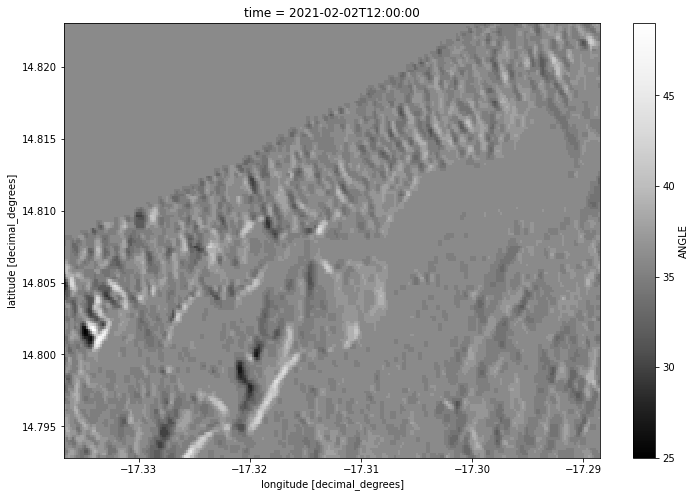

In [9]:
S1_cube.ANGLE.sel(time='2021-02-01T12:00:00.000000000', method='nearest').plot.imshow(figsize=(12,8), cmap="Greys_r")

### Extract a subset to work on a smaller region

If you would like to work on a subset, e.g. because the region of interest is smaller than the specified bounding box, you can use a WKT polygon or Shapefile to mask the region of interest. Please note however that the WKT / shapefile must be in the same coordinate reference system as the existing `xcube`.

Two methods of selection are possible:

- By masking - this keeps only the data of the WKT Polygon or shapefile

- By clipping - this creates a new bounding box, which ensures that the area of interest is within the subset but keeps the surrounding data.

In this example, we will mask our cube, using the geometry of the Mbeubeuss dump specified in the cell below.

_Note: http://geojson.io/ is a useful tool to extract geometries from a map._

In [10]:
mbeubeuss_dump_coordinates = {
  "type": "Polygon",
  "coordinates": [[[-17.321186, 14.799613], [-17.321068, 14.79856], [-17.320848, 14.798166], [-17.320107, 14.797798],
                   [-17.319863, 14.797461], [-17.319952, 14.797059], [-17.320483, 14.796498], [-17.320354, 14.795941],
                   [-17.319777, 14.795313], [-17.315692, 14.79981], [-17.314877, 14.799753], [-17.3139, 14.800282], [-17.312661, 14.800168],
                   [-17.312505, 14.800422], [-17.311535, 14.800461], [-17.31044, 14.801169], [-17.310301, 14.802082], [-17.309753, 14.801926],
                   [-17.308949, 14.802144], [-17.308542, 14.802476], [-17.308499, 14.802637], [-17.308402, 14.80273], [-17.308198, 14.802733],
                   [-17.308064, 14.802792], [-17.307911, 14.802743], [-17.307823, 14.80286], [-17.307925, 14.802963], [-17.307833, 14.803306],
                   [-17.307882, 14.803409], [-17.308316, 14.804696], [-17.308112, 14.804779],[-17.307898, 14.804862], [-17.307565, 14.805816],
                   [-17.308038, 14.8065], [-17.308596, 14.806521], [-17.309154, 14.806729], [-17.309905, 14.806231], [-17.310742, 14.806314],
                   [-17.311407, 14.806521], [-17.312051, 14.806272], [-17.312244, 14.805795], [-17.312953, 14.806065], [-17.313339, 14.8065],
                   [-17.314412, 14.806853], [-17.314927, 14.806957], [-17.315291, 14.806832 ], [-17.315656,  14.806169], [-17.31645, 14.805691],
                   [-17.316922, 14.804675], [-17.317394, 14.804654], [-17.318231,14.804322],[-17.31851,14.803077],
                   [-17.318854, 14.802974], [-17.319304, 14.8026], [-17.319314,14.80204],
                   [-17.319057, 14.801833], [-17.319218, 14.801522], [-17.319743, 14.801304], [-17.319914, 14.801122],
                   [-17.320038, 14.800567], [-17.320612, 14.800422], [-17.321186, 14.799613]]]}

In [11]:
# Mask the cube
Mbeubeuss_dump = mask_dataset_by_geometry(S1_cube, geometry=mbeubeuss_dump_coordinates)

### Plot the masked cube

In the cell below, we will check the output of the previous operation by plotting the VV band for the first time slice `isel(time=0)`.

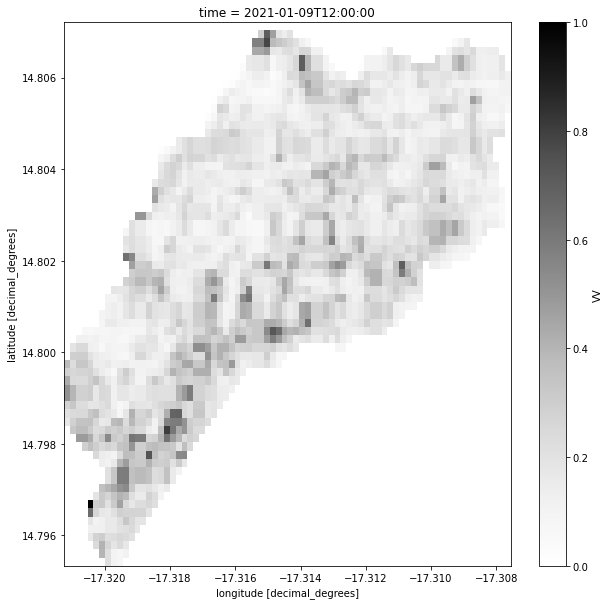

In [12]:
# Plot the masked cube
Mbeubeuss_dump.VV.isel(time=0).plot.imshow(cmap='Greys', vmin=0, vmax=1, figsize=(10, 10))

### VV change over time for a given area of interest

In the following cells, the change in VV backscatter will be assessed (for demonstration purposes only) by showing the boxplots of the Mbeubeuss dump for 3 different dates.

The following cell contains a function to convert the long timestamps from the `xcube` to a more readable format.

In [13]:
def to_datetime(datestring):
    """Convert string to datetime.
    Takes a date in the form of a string and returns a datetime object.
    The string should be in the format YYYY-MM-DD.
    """
    return dt.datetime.strptime(datestring, "%Y-%m-%d")    

### Data preparation

In the following cell, we will prepare the data for plotting in 3 steps:

- we will extract the data from 3 acquisitions that are the closest to 1st January 2021, 1st February 2021 and 1st March 2021.
- we remove the `nan` values from the arrays.
- the timestamps are extracted and converted to a more readable format.

In [14]:
# Make a list of arrays containing dump values for 3 different dates.
data = [Mbeubeuss_dump.VV.sel(time=to_datetime("2021-01-01"), method="nearest").compute().data,
        Mbeubeuss_dump.VV.sel(time=to_datetime("2021-02-01"), method="nearest").compute().data,
        Mbeubeuss_dump.VV.sel(time=to_datetime("2021-03-01"), method="nearest").compute().data]

# Remove nan values from the data for plotting
data = [x[~np.isnan(x)] for x in data]

# Automatically fetch the date (YY-MM-DD) from the acquisition.
times = [np.datetime_as_string(Mbeubeuss_dump.VV.sel(time=to_datetime("2021-01-01"), method="nearest").time.values, unit='s').split("T")[0],
         np.datetime_as_string(Mbeubeuss_dump.VV.sel(time=to_datetime("2021-02-01"), method="nearest").time.values, unit='s').split("T")[0],
         np.datetime_as_string(Mbeubeuss_dump.VV.sel(time=to_datetime("2021-03-01"), method="nearest").time.values, unit='s').split("T")[0]]

### Data plotting

In the following cell, we will plot the VV backscatter distribution over the Mbeubeuss dump for 3 selected dates as [boxplots](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51).

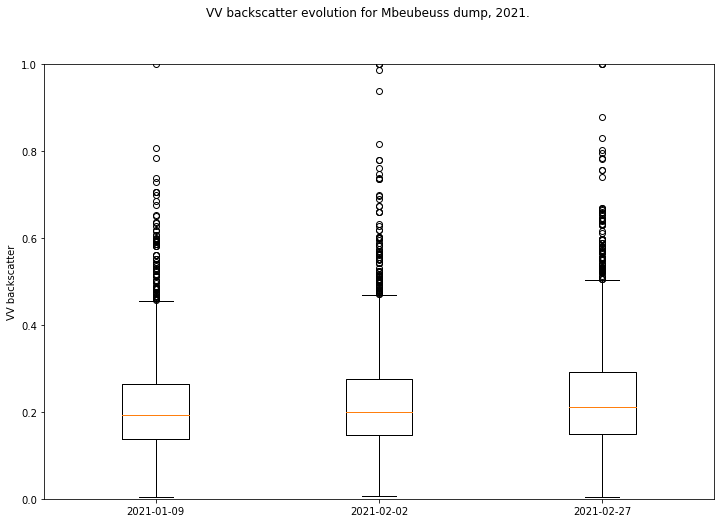

In [15]:
# Create figure
fig, ax = plt.subplots(1, figsize=(12,8))

# Plot boxplots
ax.boxplot(data)

# Set ticks to times
plt.xticks([1, 2, 3], times)

# Plot setup
ax.set_ylabel("VV backscatter")
ax.set_ylim(0, 1)
plt.suptitle("VV backscatter evolution for Mbeubeuss dump, 2021.")
plt.draw()

---

## Sentinel-1 GRD

**Mission information**

The Sentinel-1 imagery is provided by two polar-orbiting satellites, operating day and night performing C-band synthetic aperture radar imaging, enabling them to acquire imagery regardless of the weather. Main applications are for monitoring sea ice, oil spills, marine winds, waves & currents, land-use change, land deformation among others, and to respond to emergencies such as floods and earthquakes.

**S1 GRD**

Sentinel Hub currently supports Sentinel-1 Level-1 GRD (Ground Range Detected) products only. For more information about the sensor's properties and the data available, you can visit the [Sentinel Hub documentation page](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/).

**Data availability**

February 2015 to today

### Define area of interest

In the following example, we will set our AOI (covering a large part of Dakar, Senegal) using a bounding box expressed as [min_x, min_y, max_x, max_y]. Here the coordinates are in [WGS 84](https://epsg.io/4326) (EPSG **4326**), with units in degrees.

In [16]:
# Bbox
dakar_bbox = [-17.546573, 14.645375, -17.392724, 14.783846]

# Bbox EPSG
dakar_epsg = 4326

In [17]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(dakar_bbox,crs=dakar_epsg).get_geojson())

<IPython.display.GeoJSON object>

### Check Sentinel-1 GRD available bands

Using EDC inbuilt functions that query Sentinel Hub services, we can easily list the available bands for a given dataset.

In [18]:
# Create a Sentinel Hub class, using our Sentinel Hub credentials
SH = SentinelHub(**sh_credentials)

# List bands for S1-GRD
SH.band_names('S1GRD')

['VV', 'HH', 'VH', 'localIncidenceAngle', 'scatteringArea', 'shadowMask', 'HV']

### Build an xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S1GRD` for Sentinel-1 GRD. All available dataset can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the VV, HH, VH and HV polarisation bands.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set. For an example with a different coordinate system, see the section for [Airbus SPOT 6/7](#AIRBUS-SPOT-6/7).

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-1 GRD data is available from February 2015 onwards. In this example, we will fetch data for all of 2019.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [19]:
# Setup xcube
cube_config = CubeConfig(dataset_name='S1GRD',
                         band_names=['VV', 'HH', 'VH', 'HV'],
                         bbox=dakar_bbox,
                         spatial_res=0.000089,
                         time_range=['2019-01-01', '2019-12-31'],
                         time_tolerance='30M')

/opt/conda/envs/eurodatacube-0.23.2/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### Open the xcube

In the following cell we open the cube and display it's contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube.

In [20]:
# Open cube (on the fly)
cube = open_cube(cube_config, **sh_credentials)

# Display contents
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 1896, lon: 2110, time: 30)
Coordinates:
  * lat        (lat) float64 14.81 14.81 14.81 14.81 ... 14.65 14.65 14.65 14.65
  * lon        (lon) float64 -17.55 -17.55 -17.55 ... -17.36 -17.36 -17.36
  * time       (time) datetime64[ns] 2019-01-09T19:18:04 ... 2019-12-23T19:18:11
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    HH         (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    HV         (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    VH         (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    VV         (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S1GRD Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2021-04-22T11:44:29.638644
    time_coverage_start:     2019-01-09T19:17:52+00:00
    time_coverage_end:       2019-12-23T19:18:24+00:00
    time_coverage_duration:  P348DT0H0M32S
    geospatial_lon_min:      -17.546573
    geospatial_lat_min:      14.645375
    geospatial_lon_max:      -17.358783
    geospatial_lat_max:      14.814119
    processing_level:        L1B

### Visualising Urban areas using SAR

We are going to base the visualisation of the Sentinel-1 GRD data on this [custom script](https://custom-scripts.sentinel-hub.com/sentinel-1/urban_areas/) authored by Monja Šebela. Firstly, new variables need to be defined and generated. A specific date can then be called, and then stacked and visualised in a plot. 

Next, to produce the visualisation we need to define and generate Red, Green and Blue channels in the visualisation, calling the VH and VV bands in the cube and adapting them to highlight certain features for visualisation purposes. We do this by defining the new variable and attributing it a "long_name" and "units".

In [21]:
# define Red in visualisation

R = (5.5 * cube.VH)

R.attrs['long_name']='Red'
R.attrs['units']='unitless'

cube['Red']= R
        

# define Green in visualisation

G = (cube.VV)

G.attrs['long_name']='Green'
G.attrs['units']='unitless'

cube['Green']= G
        

# define Blue in visualisation

B = (8 * cube.VH)

B.attrs['long_name']='Blue'
B.attrs['units']='unitless'

cube['Blue']= B   

Secondly, we want to call the new variables that we have named as Red, Green and Blue and stack them into an array that we can then plot. In the example below, we are selecting the time slice closest to the time stamp of "2019-05-23 10:00:00". Lastly, we define the plot and visualise it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


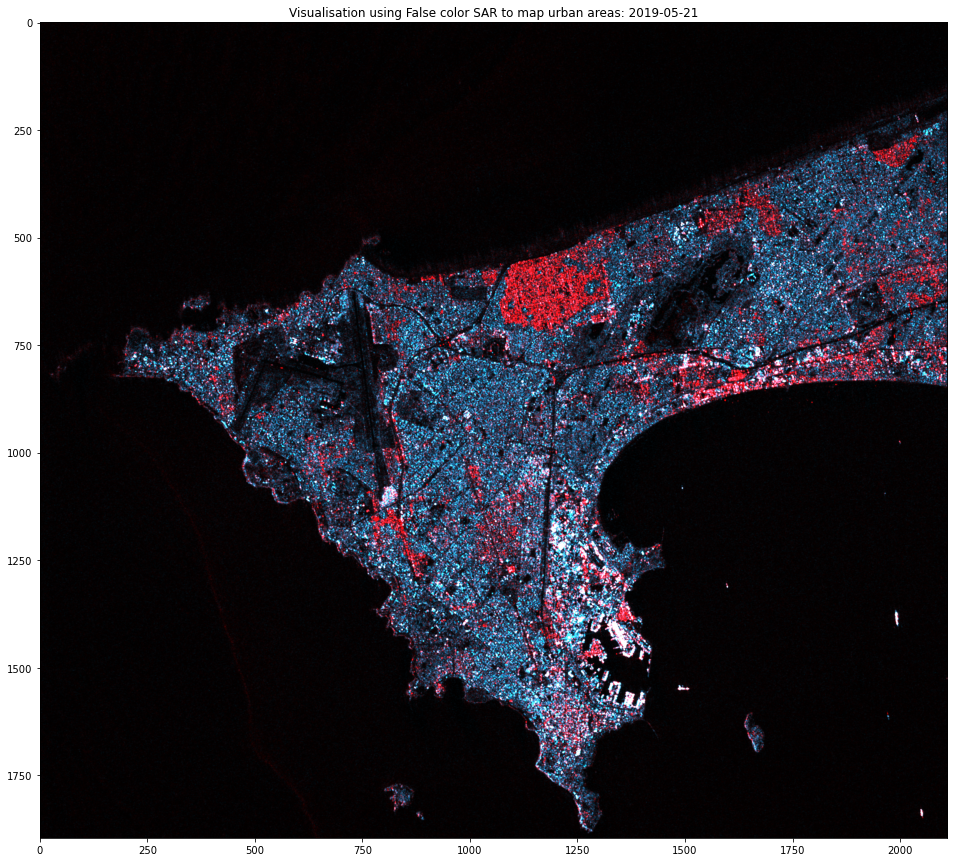

In [22]:
# Select the bands and stack them
Green = cube.Green.sel(time='2019-05-23 10:00:00', method='nearest')
Red = cube.Red.sel(time='2019-05-23 10:00:00', method='nearest')
Blue = cube.Blue.sel(time='2019-05-23 10:00:00', method='nearest')

rgb = np.dstack((Green,Red,Blue)) #Stack the three arrays

# Create plot
fig, ax = plt.subplots(1, figsize=(18,15))

ax.imshow(rgb)

ax.set_title(f"Visualisation using False color SAR to map urban areas: {str(cube.time.sel(time='2019-05-23 10:00:00', method='nearest').data).split('T')[0]}")

plt.show()

---

## Sentinel-2 L1C
**Mission information**

SENTINEL-2 is a European wide-swath, high-resolution, multi-spectral imaging mission. Its high-resolution optical images have many applications, including land monitoring, emergency response and security services assistance. The satellite's multispectral imager provides a versatile set of 13 spectral bands spanning from the visible and near infrared to the shortwave infrared.


**Level 1C**

Level 1C offers Top of the atmosphere (TOA) reflectance data. For more information about the sensor's properties and the data available, you can visit the [Sentinel Hub documentation page](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/).

**Data availability**

June 2015 to today

### Define area of interest

In the following example, we will set our AOI (covering a large part of Dakar, Senegal) using a bounding box expressed as [min_x, min_y, max_x, max_y]. Here the coordinates are in [WGS 84](https://epsg.io/4326) (EPSG **4326**), with units in degrees.

In [23]:
# Bbox
dakar_bbox = [-17.546573, 14.645375, -17.392724, 14.783846]

# Bbox EPSG
dakar_epsg = 4326

In [24]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(dakar_bbox,crs=dakar_epsg).get_geojson())

<IPython.display.GeoJSON object>

### Check Sentinel-2 L1C available bands

Using EDC inbuilt functions that query Sentinel Hub services, we can list the available bands for a given dataset.

In [25]:
# Create a Sentinel Hub class
SH = SentinelHub(**sh_credentials)

# List bands for S2-L1C
SH.band_names('S2L1C')

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B10',
 'B11',
 'B12',
 'viewZenithMean',
 'viewAzimuthMean',
 'sunZenithAngles',
 'sunAzimuthAngles',
 'CLM',
 'CLP']

### Build xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S2L1C` for Sentinel-2 Level 1C. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the Blue, Green, Red and Near Infrared bands (B02, B03, B04, B08 respectively).

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set. For an example with a different coordinate system, see the section for [Airbus SPOT 6/7](#AIRBUS-SPOT-6/7).

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-2 L1C data is available from November 2015 onwards. In this example, we will fetch data from June to August 2019.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [26]:
# Setup xcube
cube_config = CubeConfig(dataset_name='S2L1C',
                         band_names=['B02', 'B03', 'B04', 'B08'],
                         bbox=dakar_bbox,
                         spatial_res=0.000089,
                         time_range=['2019-06-01', '2019-08-31'],
                         time_tolerance='30M')

/opt/conda/envs/eurodatacube-0.23.2/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### Open the xcube

In the following cell we open the cube and display its contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube.

In [27]:
# Open cube (on the fly)
cube = open_cube(cube_config, **sh_credentials)

# Display contents
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 1896, lon: 2110, time: 17)
Coordinates:
  * lat        (lat) float64 14.81 14.81 14.81 14.81 ... 14.65 14.65 14.65 14.65
  * lon        (lon) float64 -17.55 -17.55 -17.55 ... -17.36 -17.36 -17.36
  * time       (time) datetime64[ns] 2019-06-02T11:47:35 ... 2019-08-26T11:47:28
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(17, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L1C Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2021-04-22T11:44:41.461669
    time_coverage_start:     2019-06-02T11:47:34+00:00
    time_coverage_end:       2019-08-26T11:47:29+00:00
    time_coverage_duration:  P84DT23H59M55S
    geospatial_lon_min:      -17.546573
    geospatial_lat_min:      14.645375
    geospatial_lon_max:      -17.358783
    geospatial_lat_max:      14.814119
    processing_level:        L1C

### Compute an additional band

In the following cell we will compute a new band based on existing bands in the xcube. In this example we will compute the Normalized difference vegetation index (NDVI) for each existing timestamp. [NDVI](https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/) is a commonly used index to quantify green vegetation, and is derived from Sentinel-2 bands 4 and 8.

Firstly, we define the NDVI formula:

In [28]:
# Define NDVI equation
cube['NDVI'] = (cube.B08 - cube.B04) / (cube.B04 + cube.B08)

# Set band attributes
cube['NDVI'].attrs['long_name'] = 'Normalized Difference Vegetation Index'
cube['NDVI'].attrs['units'] = 'unitless'

In [29]:
# Display the calculated NDVI band
cube.NDVI

<xarray.DataArray 'NDVI' (time: 17, lat: 1896, lon: 2110)>
dask.array<truediv, shape=(17, 1896, 2110), dtype=float32, chunksize=(1, 948, 1055), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14.81 14.81 14.81 14.81 ... 14.65 14.65 14.65 14.65
  * lon      (lon) float64 -17.55 -17.55 -17.55 -17.55 ... -17.36 -17.36 -17.36
  * time     (time) datetime64[ns] 2019-06-02T11:47:35 ... 2019-08-26T11:47:28
Attributes:
    long_name:  Normalized Difference Vegetation Index
    units:      unitless

Now we have generated this new band, let's visualise the values for a pixel over the time period. In this example, the coordinates of a point located in an Urban reserve (Réserve Naturelle Urbaine de la Grande Niaye de Pikine et Dépendance) were selected.

In [30]:
# Set latitude and longitude of point to query
point_lat = 14.7678
point_lon = -17.4023

# Get timeseries
timeseriesNDVI = cube.NDVI.sel(lat=point_lat, lon=point_lon, method='nearest').to_series()

### Plot NDVI timeseries for a given location
Using matplotlib we can visualise how NDVI changes over time.

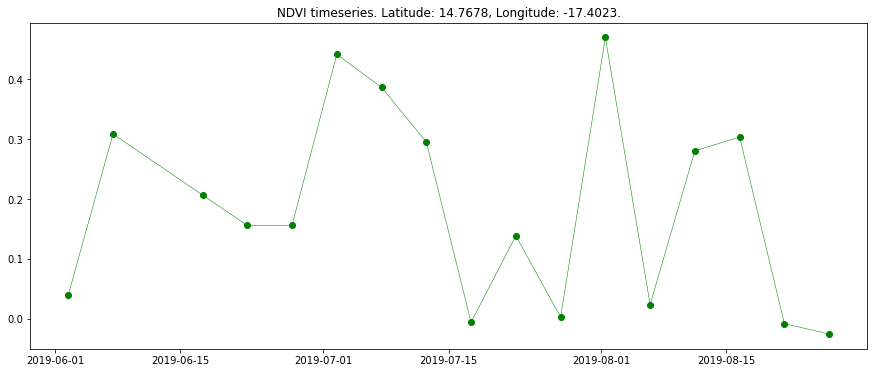

In [31]:
# Plot NDVI timeseries
_, ax = plt.subplots(1, figsize=(15, 6))
ax.plot(timeseriesNDVI, color="green", marker="o", linewidth=0.5)
ax.set_title(f"NDVI timeseries. Latitude: {point_lat}, Longitude: {point_lon}.")
plt.show()

---

## Sentinel-2 L2A
**Mission information**

SENTINEL-2 is a European wide-swath, high-resolution, multi-spectral imaging mission. Its high-resolution optical images have many applications, including land monitoring, emergency response and security services assistance. The satellite's multispectral imager provides a versatile set of 13 spectral bands spanning from the visible and near infrared to the shortwave infrared.


**Level 2A**

Level 2A offers Bottom of the atmosphere (BOA) reflectance data. For more information about the sensor's properties and the data available, you can visit the [Sentinel Hub documentation page](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/).

**Data availability**

January 2017 to today

### Define area of interest

In the following example, we will set our AOI (covering a large part of Dakar, Senegal) using a bounding box expressed as [min_x, min_y, max_x, max_y]. Here the coordinates are in [WGS 84](https://epsg.io/4326) (EPSG **4326**), with units in degrees.

In [32]:
# Bbox
dakar_bbox = [-17.546573, 14.645375, -17.392724, 14.783846]

# Bbox EPSG
dakar_epsg = 4326

In [33]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(dakar_bbox,crs=dakar_epsg).get_geojson())

<IPython.display.GeoJSON object>

### Check Sentinel-2 L2A available bands

Using EDC inbuilt functions that query Sentinel Hub services, we can list the available bands for a given dataset.

In [34]:
# Create a Sentinel Hub class
SH = SentinelHub(**sh_credentials)

# List bands for S2-L2A
SH.band_names('S2L2A')

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12',
 'SCL',
 'SNW',
 'CLD',
 'viewZenithMean',
 'viewAzimuthMean',
 'sunZenithAngles',
 'sunAzimuthAngles',
 'AOT',
 'CLM',
 'CLP']

### Build xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S2L2A` for Sentinel-2 Level 2A. All available dataset can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the Blue, Green, Red and Near Infrared bands (B02, B03, B04, B08 respectively).

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set. For an example with a different coordinate system, see the section for [Airbus SPOT 6/7](#AIRBUS-SPOT-6/7).

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 10 meters, we set the resolution to 0.000089 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-2 L2A data is available from January 2017 onwards. In this example, we will fetch data for May 2019.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [35]:
# Setup xcube
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B02', 'B03', 'B04', 'B08'],
                         bbox=dakar_bbox,
                         spatial_res=0.000089,
                         time_range=['2019-05-01', '2019-05-31'],
                         time_tolerance='30M')

/opt/conda/envs/eurodatacube-0.23.2/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### Open the xcube

In the following cell we open the cube and display its contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube.

In [36]:
# Open cube (on the fly)
cube = open_cube(cube_config, **sh_credentials)

# Display contents
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 1896, lon: 2110, time: 6)
Coordinates:
  * lat        (lat) float64 14.81 14.81 14.81 14.81 ... 14.65 14.65 14.65 14.65
  * lon        (lon) float64 -17.55 -17.55 -17.55 ... -17.36 -17.36 -17.36
  * time       (time) datetime64[ns] 2019-05-03T11:47:34 ... 2019-05-28T11:47:29
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 948, 1055), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2021-04-22T11:45:15.845907
    time_coverage_start:     2019-05-03T11:47:34+00:00
    time_coverage_end:       2019-05-28T11:47:30+00:00
    time_coverage_duration:  P24DT23H59M56S
    geospatial_lon_min:      -17.546573
    geospatial_lat_min:      14.645375
    geospatial_lon_max:      -17.358783
    geospatial_lat_max:      14.814119
    processing_level:        L2A

### Compute and visualise an additional band

In the following cell we will compute a new band based on existing bands in the xcube. In this example we will compute the Normalized difference vegetation index (NDVI) for each existing timestamp. [NDVI](https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/) is a commonly used index to quantify green vegetation, and is derived from Sentinel-2 bands 4 and 8.

Firstly, we define the NDVI formula and create a new variable attributing a "long_name" and "units".

In [37]:
# Define NDVI equation and set as band
ndvi = (cube.B08 - cube.B04) / (cube.B04 + cube.B08)

ndvi.attrs['long_name'] = 'Normalized Difference Vegetation Index'
ndvi.attrs['units'] = 'unitless'

cube['NDVI'] = ndvi

Secondly, we will call this variable for a specific date and then visualise it. In this example, we will specify a date of interest and fetch the closest acquisition in time available.

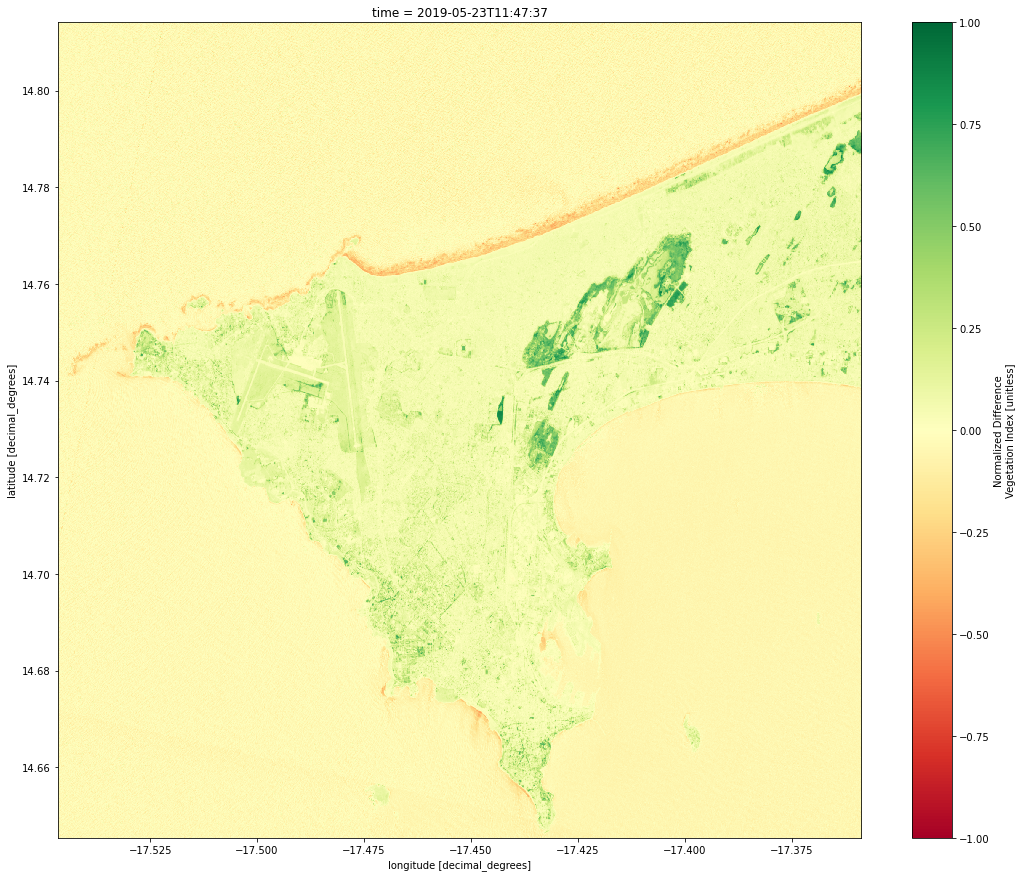

In [38]:
cube.NDVI.sel(time='2019-05-23 10:00:00', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn', figsize=(18, 15))

---

## Landsat-8 Collection 2

**Mission information**

Landsat 8 is the most recently launched Landsat satellite (provided by NASA/USGS) and carries the Operational Land Imager (OLI) and the Thermal Infrared Sensor (TIRS) instruments. These two sensors provide seasonal coverage of the global landmass. Landsat-8 Level-1 provides global top-of-atmosphere reflectance and brightness-temperature, whereas Level-2 provides global surface reflectance and surface temperature science products. Landsat Level-2 science products are generated from Collection 2 Level-1 inputs that meet the <76 degrees Solar Zenith Angle constraint and include the required auxiliary data inputs to generate a scientifically viable product.

**Collection 2**

For more information about the sensor's properties and the data available, you can visit the Sentinel Hub documentation pages for [Level 1](https://docs.sentinel-hub.com/api/latest/data/landsat-8/) and [Level2](https://docs.sentinel-hub.com/api/latest/data/landsat-8-l2/). Additional information about Collection 2 can be found on the [dedicated USGS page](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2-level-2-science-products).

**Data availability**

Since February 2013.


### Fetch an image from Landsat-8 Collection 2 Level 1 and Level 2

Below we define the cells to retrieve data for Landsat 8 Collection 2. 

First, we need to set the input parameters. Currently, Collection 2 data is not available through the `xcube` package. Therefore, in this example, we will access the data from Sentinel Hub using the [sentinelhub-py library](https://sentinelhub-py.readthedocs.io/en/latest/index.html).

In [39]:
# Sentinel Hub configuration for the Python package
config = SHConfig()
config.sh_client_id = environ["SH_CLIENT_ID"]
config.sh_client_secret = environ["SH_CLIENT_SECRET"]

The Collection 2 is only recently available through Sentinel Hub services and the `sentinelhub-py` package has not yet been updated to contain the settings for the Collection 2 by default. This means that the `DataCollection` object has to be specified manually, as shown below.

In [40]:
# Define a new DataCollection for Level-1 data
DataCollection.define_from(
            DataCollection.LANDSAT8,
            "LOTL1",
            service_url="https://services-uswest2.sentinel-hub.com",
            wfs_id="DSS12",  # https://www.sentinel-hub.com/develop/api/ogc/standard-parameters/wfs/
            api_id="LOTL1",
            catalog_id="landsat-8-l1c",
            processing_level="L1C",
            bands=("B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B10", "B11", "BQA", "QA_RADSAT", "VAA", "VZA", "SAA", "SZA", "dataMask"),
)

<DataCollection.LOTL1: DataCollectionDefinition(
  api_id: LOTL1
  catalog_id: landsat-8-l1c
  wfs_id: DSS12
  service_url: https://services-uswest2.sentinel-hub.com
  collection_type: Landsat 8
  processing_level: L1C
  bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'BQA', 'QA_RADSAT', 'VAA', 'VZA', 'SAA', 'SZA', 'dataMask')
  is_timeless: False
  has_cloud_coverage: True
)>

In [41]:
# Define a new DataCollection for Level-2 data
DataCollection.define_from(
            DataCollection.LANDSAT8,
            "LOTL2",
            service_url="https://services-uswest2.sentinel-hub.com",
            wfs_id="DSS13",  # https://www.sentinel-hub.com/develop/api/ogc/standard-parameters/wfs/
            api_id="LOTL2",
            catalog_id="landsat-8-l2a",
            processing_level="L2A",
            bands=("B01", "B02", "B03", "B04", "B05", "B06", "B07", "B10", "BQA", "QA_RADSAT", "SR_QA_AEROSOL", "ST_QA", 
                   "ST_TRAD", "ST_URAD", "ST_DRAD", "ST_ATRAN", "ST_EMIS", "ST_EMSD", "ST_CDIST", "dataMask"),
)

<DataCollection.LOTL2: DataCollectionDefinition(
  api_id: LOTL2
  catalog_id: landsat-8-l2a
  wfs_id: DSS13
  service_url: https://services-uswest2.sentinel-hub.com
  collection_type: Landsat 8
  processing_level: L2A
  bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B10', 'BQA', 'QA_RADSAT', 'SR_QA_AEROSOL', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'ST_DRAD', 'ST_ATRAN', 'ST_EMIS', 'ST_EMSD', 'ST_CDIST', 'dataMask')
  is_timeless: False
  has_cloud_coverage: True
)>

### Define area of interest

In the following example, we will set our AOI (covering a large part of Dakar, Senegal) using a bounding box expressed as [min_x, min_y, max_x, max_y]. Here the coordinates are in [WGS 84](https://epsg.io/4326) (EPSG **4326**), with units in degrees. We also calculate the AOI in pixels based upon the resolution of Landsat 8 which is 30m.

_Note: with `sentinelhub-py` , the size of the image cannot be more than 2500px * 2500px, else the request will fail._

In [42]:
dakar_bbox = [-17.546573, 14.645375, -17.392724, 14.783846]
dakar_epsg = 4326

resolution = 30
dakar_bbox = BBox(bbox=dakar_bbox, crs=dakar_epsg)
dakar_size = bbox_to_dimensions(dakar_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {dakar_size} pixels')

Image shape at 30 m resolution: (558, 505) pixels


### Define an evalscript

Now that the input parameters are defined we will use an [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/) to visualise the data that we are requesting. In this example, we are requesting Band 3, 4 & 5 (Green, Red, NIR) and returning them in a 3-band image. 

In [43]:
evalscript_false_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B05", "B04", "B03"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B05, sample.B04, sample.B03];
    }
"""

### Create a Sentinel Hub request for Level 1 and Level 2 data

Based on the parameters set in the previous cells, we will build a Sentinel Hub request for Landsat-8 Collection 2 Level 1 and Level 2, that will return False Colour RGB png images.

In [44]:
l8_l1c = SentinelHubRequest(
    evalscript=evalscript_false_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LOTL1,
            time_interval=('2020-05-01', '2020-08-30'),
            other_args = {"dataFilter":{"mosaickingOrder":"leastCC"}}
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=dakar_bbox,
    size=dakar_size,
    config=config
)

l8_l2a = SentinelHubRequest(
    evalscript=evalscript_false_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LOTL2,
            time_interval=('2020-05-01', '2020-08-30'),
            other_args = {"dataFilter":{"mosaickingOrder":"leastCC"}}
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=dakar_bbox,
    size=dakar_size,
    config=config
)

### Run the requests

In [45]:
false_colour_l1c = l8_l1c.get_data()
false_colour_l2a = l8_l2a.get_data()

### Plot the false colour RGB images

In the next cell, we will use a plotting function for the request results (https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/utils.py).

In [46]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

Lastly, let's visualise the Level 1 and 2 images! The image type is UINT8 which means that the image bands have values of 0-255. To visualise them on a scale of 0 to 1 we need to divide by 255 first. You can also adjust the factor to brighten the image if you wish. 

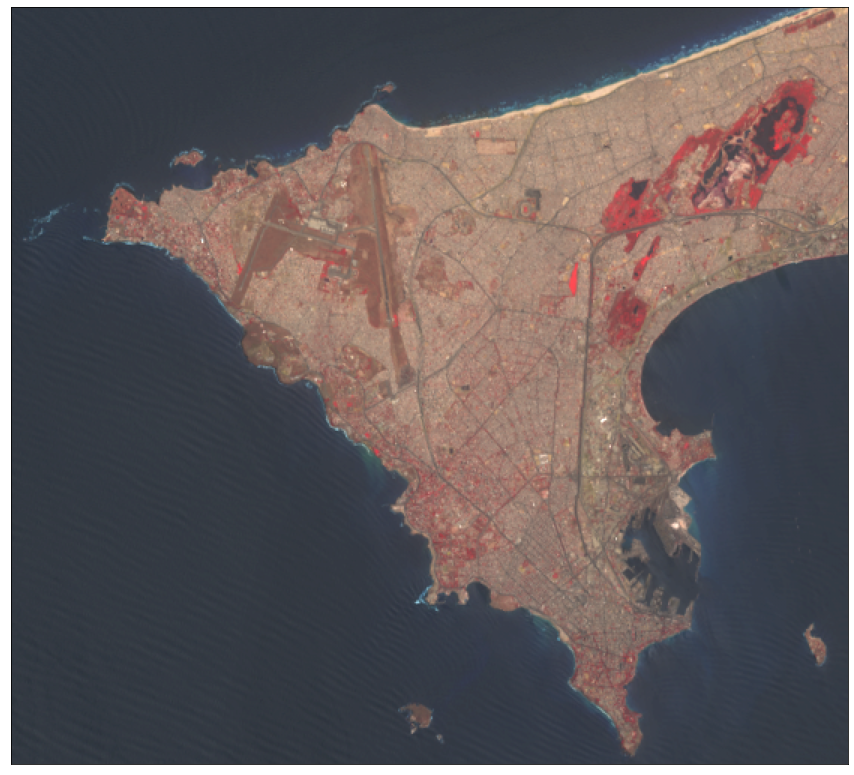

In [47]:
# Level 1
image_l1c = false_colour_l1c[0]

# plot function
# factor 1/255 to scale between 0-1
# factor 2.5 to increase brightness
plot_image(image_l1c, factor=2.5/255, clip_range=(0,1))

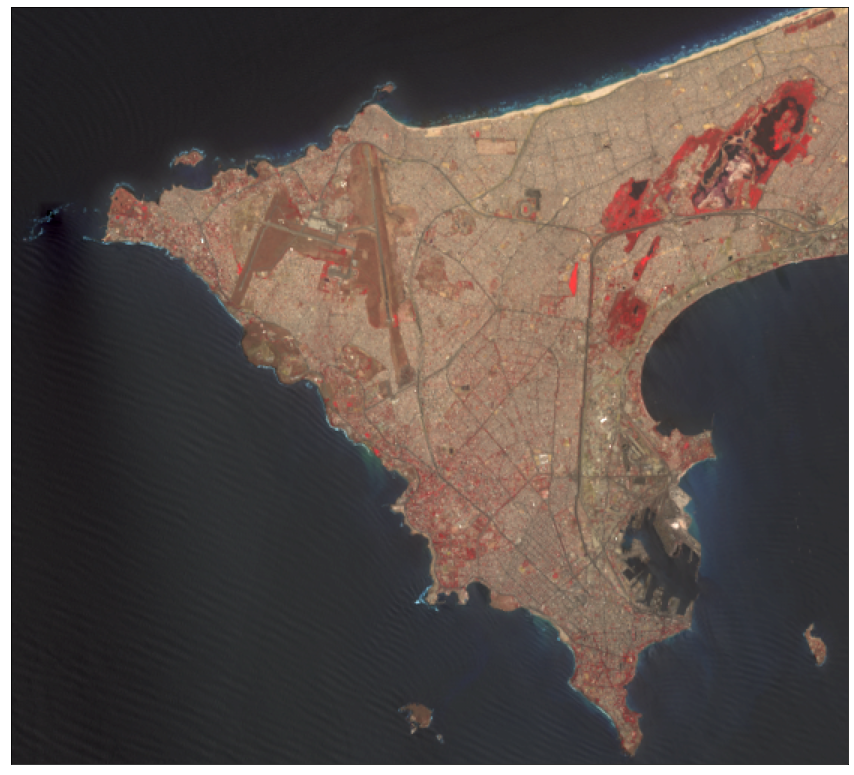

In [48]:
# Level 2
image_l2a = false_colour_l2a[0]

# plot function
# factor 1/255 to scale between 0-1
# factor 2.5 to increase brightness
plot_image(image_l2a, factor=2.5/255, clip_range=(0,1))

---

## AIRBUS SPOT 6/7

SPOT 6/7 is a satellite constellation providing very high-resolution optical imagery and is owned by [Airbus](https://www.intelligence-airbusds.com/en/8693-spot-67).

**Mission information**

SPOT 6/7 is composed of two twin satellites orbiting the Earth 180° apart. The following table lists the bands available through Sentinel Hub services and their resolution:

| Name | Description | Resolution |
|-|-|-|
| B0 | Blue, 454-519 nm | 6m |
| B1 | Green, 527-587 nm | 6m |
| B2 | Red, 624-694 nm | 6m |
| B3 | Near Infrared, 756-880 nm | 6m |
| PAN | Panchromatic, 455-744 nm | 1.5m |
| dataMask | The mask of data/no data pixels | N/A |


**Data availability**

SPOT 6/7 data can be accessed as a [BYOC collection](https://docs.sentinel-hub.com/api/latest/data/byoc/#accessing-data), i.e. by specifying a `collection_ID`.

Images acquired on the following dates are available within the collection:

- 2012-10-17
- 2012-10-27
- 2012-12-06
- 2012-12-08
- 2012-12-15
- 2012-12-18
- 2012-12-20
- 2012-12-27
- 2013-03-13
- 2014-10-19
- 2015-02-21
- 2015-04-20
- 2015-12-23
- 2016-04-24
- 2017-03-22
- 2017-04-17
- 2018-03-01
- 2018-10-22
- 2019-10-20
- 2020-10-18
- 2021-02-25

### Define area of interest

In the following example, we will set our AOI (covering the port of Dakar) using a GeoJSON polygon geometry. Here the coordinates are in [WGS 84 / Pseudo-Mercator](https://epsg.io/3857) (EPSG **3857**), with units in meters.

In [49]:
# Bbox
dakar_geometry = {
  "type": "Polygon",
  "coordinates": [
    [
      [
        -1939522.159759,
        1654269.238697
      ],
      [
        -1939187.64469,
        1653887.045024
      ],
      [
        -1939331.024194,
        1653724.663382
      ],
      [
        -1939206.791642,
        1653437.99502
      ],
      [
        -1939025.229553,
        1652922.092265
      ],
      [
        -1939178.405172,
        1651173.533333
      ],
      [
        -1940544.740602,
        1651555.800865
      ],
      [
        -1940994.026067,
        1652434.969169
      ],
      [
        -1941127.720775,
        1652883.886191
      ],
      [
        -1940410.934574,
        1654020.886953
      ],
      [
        -1939503.012807,
        1654718.303547
      ],
      [
        -1939455.256746,
        1654555.916536
      ],
      [
        -1939522.159759,
        1654269.238697
      ]
    ]
  ]
}

# Bbox EPSG number and code (see https://docs.sentinel-hub.com/api/latest/api/process/crs/)
dakar_epsg= 3857
dakar_projection = "http://www.opengis.net/def/crs/EPSG/0/3857"

# Build a Sentinel Hub geometry object from the input polygon
dakar_geom = geometry.Geometry(dakar_geometry,crs=dakar_epsg)

In [50]:
# Plot the geometry on a map
IPython.display.GeoJSON(dakar_geom.transform(4326).get_geojson())

<IPython.display.GeoJSON object>

### Build xcubes

To save processing resources, we will request two `xcube` arrays rather than select the time-range covering all acquisitions. First, we will request two `xcube` arrays for the 17th October 2017 and the 25th February 2020. In a following step, the `xcube` arrays will be merged.

In the following cell we will specify the input parameters needed to build the xcube arrays. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `CUSTOM` because SPOT images are available as a BYOC collection.

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the Blue, Green, Red and Near Infrared bands (B0, B1, B2, B3 respectively).

- _bbox_: the bounding box that sets the extent of the AOI. The bounding box covering the input geometry can be directly called from the `sentinelhub.geometry` object created above.

- _crs_: if the coordinate reference system isn't in WGS84 (EPSG:4326) as the default value, it is specified using an [opengis URL](https://docs.sentinel-hub.com/api/latest/api/process/crs/). Here, we are using EPSG:3857.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in meters. Since we are not requesting the panchromatic band, the nominal resolution of the R, G, B and IR bands is used (6m).

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. For each date, we request a separate cube.

- _time_period_: Necessary when requesting a BYOC collection. The time period string denotes the temporal aggregation period to be used. Here `1d` means that if several images are available for 1 given date (not the case), they will be aggregated.

- _collection_id_: the Sentinel Hub BYOC collection ID for Airbus SPOT.

In [51]:
# Setup xcube for T1
cube_config_t1 = CubeConfig(dataset_name='CUSTOM',
                         band_names=['B0', 'B1', 'B2', 'B3'],
                         bbox=dakar_geom.bbox,
                         crs=dakar_projection,
                         spatial_res=6,
                         time_range=['2012-10-17', '2012-10-17'],
                         time_period="1d",
                         collection_id=spot_collection)

# Setup xcube for T2
cube_config_t2 = CubeConfig(dataset_name='CUSTOM',
                         band_names=['B0', 'B1', 'B2', 'B3'],
                         bbox=dakar_geom.bbox,
                         crs=dakar_projection,
                         spatial_res=6,
                         time_range=['2021-02-25', '2021-02-25'],
                         time_period="1d",
                         collection_id=spot_collection)

### Open cubes

In [52]:
SPOT_t1 = open_cube(cube_config_t1, **sh_credentials)
SPOT_t2 = open_cube(cube_config_t2, **sh_credentials)

### Merge cubes to form a single multi-temporal cube.

In [53]:
# Initialise merger with an existing cube
cc = CubesCombiner(SPOT_t1)

# Merge the two cubes
SPOT_cube = cc.process_cubes([SPOT_t1, SPOT_t2])

### Explore the merged `xcube`

We will first explore the variables and metadata contained in the `xcube` by printing its contents.

In [54]:
SPOT_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 2, x: 350, y: 591)
Coordinates:
  * time       (time) datetime64[ns] 2012-10-17T12:00:00 2021-02-25T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
  * x          (x) float64 -1.941e+06 -1.941e+06 ... -1.939e+06 -1.939e+06
  * y          (y) float64 1.655e+06 1.655e+06 1.655e+06 ... 1.651e+06 1.651e+06
Dimensions without coordinates: bnds
Data variables:
    B0         (time, y, x) float32 dask.array<chunksize=(2, 591, 350), meta=np.ndarray>
    B1         (time, y, x) float32 dask.array<chunksize=(2, 591, 350), meta=np.ndarray>
    B2         (time, y, x) float32 dask.array<chunksize=(2, 591, 350), meta=np.ndarray>
    B3         (time, y, x) float32 dask.array<chunksize=(2, 591, 350), meta=np.ndarray>

### Plot a timeslice from the xcube

In a second step we will plot Band 0 (blue) for a time slice by selecting its number (0...n; 0 being the first slice and n the last).

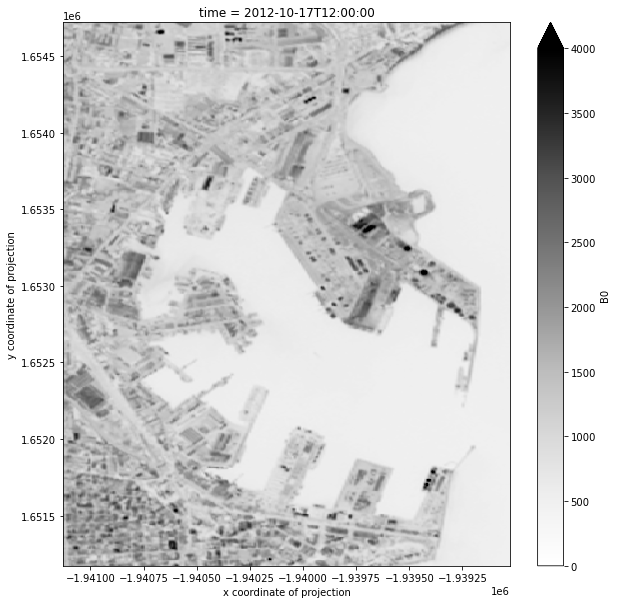

In [55]:
SPOT_cube.B0.isel(time=0).plot.imshow(cmap='Greys', vmin=0, vmax=4000, figsize=(10, 10))

## Extract a subset to work on a smaller region

If you would like to work on a subset, e.g. because the region of interest is smaller than the specified bounding box, you can use a WKT polygon or Shapefile to mask the region of interest. Please note however that the WKT / shapefile must be in the same coordinate reference system as the existing `xcube`.

Two methods of selection are possible:

- By masking - this keeps only the data of the WKT Polygon or shapefile

- By clipping - this creates a new bounding box, which ensures that the area of interest is within the subset but keeps the surrounding data.

In this example, we will mask our cube, using the geometry specified earlier.

In [56]:
# Mask the cube
Dakar_port = mask_dataset_by_geometry(SPOT_cube, geometry=dakar_geom.get_geojson())

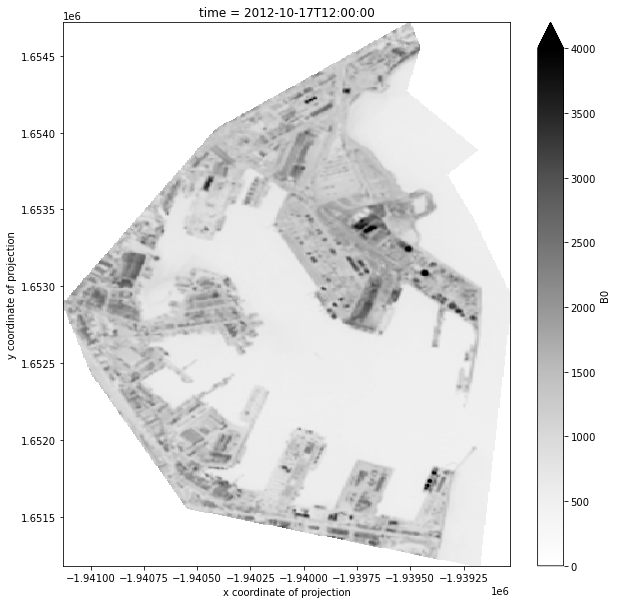

In [57]:
# Plot the masked cube
Dakar_port.B0.isel(time=0).plot.imshow(cmap='Greys', vmin=0, vmax=4000, figsize=(10, 10))

## Basic processing example: NDWI change

In the following cells, the change in Normalized Difference Water Index ([NDWI](https://custom-scripts.sentinel-hub.com/sentinel-2/ndwi/)) will be assessed (for demonstration purposes only).

### Plot RGB images

In a first step we will plot the True Color RGB of Dakar harbor for each date side-by-side. 

To visualise RGB images, two steps are needed:

- stack the red, green and blue bands

- normalise the bands between 0 and 1. SPOT data are expressed in `DN` as `DN = reflectance * 10000`. The typical range for a SPOT image is 0 - 4000. Therefore we will normalise 0 - 4000 to 0 - 1 for visualisation purposes.

In [58]:
# T1 RGB
t1_rgb = np.dstack((Dakar_port.B2.isel(time=0)/4000, Dakar_port.B1.isel(time=0)/4000, Dakar_port.B0.isel(time=0)/4000))

# T2 RGB
t2_rgb = np.dstack((Dakar_port.B2.isel(time=1)/4000, Dakar_port.B1.isel(time=1)/4000, Dakar_port.B0.isel(time=1)/4000))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


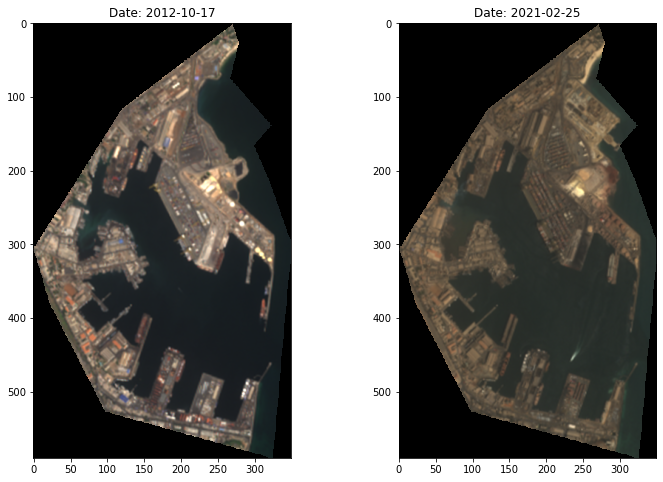

In [59]:
# Plot RGB images together
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,8))

# Set ticks to times
ax.imshow(t1_rgb)
ax2.imshow(t2_rgb)

# Set dates as titles
ax.set_title(f"Date: {str(Dakar_port.time[0].data).split('T')[0]}")
ax2.set_title(f"Date: {str(Dakar_port.time[1].data).split('T')[0]}")

plt.show()

### Plot change in NDWI

To monitor change in NDWI, and potentially detect areas encroached on the ocean, we will plot the difference in NDWI between the two available dates. Looking at the RGB images and the NDWI change map (large red zone), we can see a new area in the port that was built out over the ocean.

In [60]:
# Calculate NDWI
Dakar_port['ndwi'] = (Dakar_port.B1 - Dakar_port.B3) / (Dakar_port.B1 + Dakar_port.B3)

# Compute chaange between two dates
ndwi_change = Dakar_port.ndwi.isel(time=1) - Dakar_port.ndwi.isel(time=0)

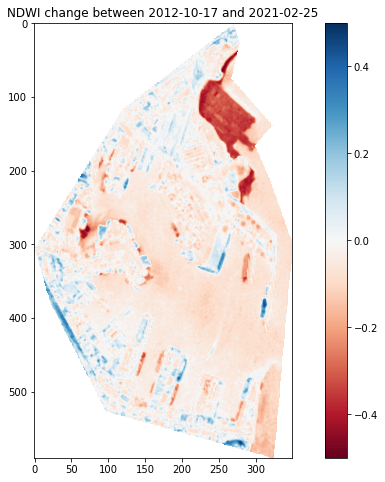

In [61]:
# Plot NDWI change
fig, ax = plt.subplots(1, figsize=(12,8))

# Set ticks to times
change = ax.imshow(ndwi_change, cmap="RdBu", vmin=-0.5, vmax=0.5)
plt.colorbar(change)
ax.set_title(f"NDWI change between {str(Dakar_port.time[0].data).split('T')[0]} and {str(Dakar_port.time[1].data).split('T')[0]}")

plt.show()

---

## AIRBUS Pleiades

Pléiades is a satellite constellation providing very high-resolution optical imagery and is owned by [Airbus](https://www.intelligence-airbusds.com/en/8693-spot-67).

**Mission information**

Pléiades is composed of two twin satellites orbiting the Earth 180° apart. The satellites deliver 0.5 m optical imagery and offer a daily revisit capability to any point on the globe. The following table lists the bands available through Sentinel Hub services and their resolution:

| Name | Description | Resolution |
|-|-|-|
| B0 | Blue, 430-550 nm | 2m |
| B1 | Green, 490-610 nm | 2m |
| B2 | Red, 600-720 nm | 2m |
| B3 | Near Infrared, 750-950 nm | 2m |
| PAN | Panchromatic, 480-830 nm | 0.5m |
| dataMask | The mask of data/no data pixels | N/A |


**Data availability**

Pléiades data can be accessed as a [BYOC collection](https://docs.sentinel-hub.com/api/latest/data/byoc/#accessing-data), i.e. by specifying a `collection_ID`.

Images acquired on the following dates are available within the collection:

- 2012-03-13
- 2012-05-06
- 2012-10-02
- 2013-02-23
- 2013-10-20
- 2014-10-14
- 2015-11-07
- 2016-03-10
- 2016-12-08
- 2017-10-09
- 2017-10-15
- 2019-03-06
- 2019-12-24
- 2020-06-24
- 2020-10-18

More acquisitions will be added during the contest, stay tuned for news!

### Define area of interest

In the following example, we will set our AOI (covering the Mbao industrial area, Dakar, Senegal - see http://www.sar.sn/) using a GeoJSON polygon geometry. Here the coordinates are in [WGS 84 / UTM zone 28N](https://epsg.io/32628) (EPSG **32628**), with units in meters.

In [62]:
# Bbox
mbao_geometry = {
  "type": "Polygon",
  "coordinates": [
    [
      [
        246910.013036,
        1630461.326004
      ],
      [
        246752.787159,
        1631786.114943
      ],
      [
        248484.369728,
        1631997.760134
      ],
      [
        248751.899486,
        1631930.66922
      ],
      [
        248656.087821,
        1631614.745376
      ],
      [
        248804.78545,
        1630340.550845
      ],
      [
        248371.768609,
        1630501.232138
      ],
      [
        248252.122139,
        1630121.242429
      ],
      [
        246910.013036,
        1630461.326004
      ]
    ]
  ]
}

# Bbox EPSG number and code (see https://docs.sentinel-hub.com/api/latest/api/process/crs/)
mbao_epsg = 32628
mbao_projection= "http://www.opengis.net/def/crs/EPSG/0/32628"

# Build a Sentinel Hub geometry object from the input polygon
mbao_geom = geometry.Geometry(mbao_geometry,crs=mbao_epsg)

In [63]:
# Plot the geometry on a map
IPython.display.GeoJSON(mbao_geom.transform(4326).get_geojson())

<IPython.display.GeoJSON object>

### Build xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `CUSTOM` because Pléiades images are available as a BYOC collection.

- _band_names_: the band names to be used in the xcube array. Here, we will call the Blue, Green, Red and Panchromatic bands (B0, B1, B2, PAN respectively).

- _bbox_: the bounding box that sets the extent of the AOI. The bounding box covering the input geometry can be directly called from the `sentinelhub.geometry` object created above.

- _crs_: if the coordinate reference system isn't in WGS84 (EPSG:4326) as the default value, it is specified using an [opengis URL](https://docs.sentinel-hub.com/api/latest/api/process/crs/). Here, we are using EPSG:32628.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in meters. Since we are also requesting the panchromatic band, and will perform pan-sharpening, we will request the cube at 0.5 meters resolution.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. For this example, we will request a single date.

- _time_period_: Necessary when requesting a BYOC collection. The time period string denotes the temporal aggregation period to be used. Here `1d` means that if several images are available for 1 given date (not the case), they will be aggregated.

- _collection_id_: the Sentinel Hub BYOC collection ID for Airbus Pléiades.

In [64]:
# Setup xcube for Pléiades
cube_config = CubeConfig(dataset_name='CUSTOM',
                         band_names=['B0', 'B1', 'B2', 'PAN'],
                         bbox=mbao_geom.bbox,
                         crs=mbao_projection,
                         spatial_res=0.5,
                         time_range=['2019-12-24', '2019-12-24'],
                         time_period="1d",
                         collection_id=pleiades_collection)

### Open cube

In [65]:
Pleiades_cube = open_cube(cube_config, **sh_credentials)

### Explore the `xcube`

We will first explore the variables and metadata contained in the `xcube` by printing its contents.

In [66]:
Pleiades_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 1, x: 4184, y: 3828)
Coordinates:
  * time       (time) datetime64[ns] 2019-12-24T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
  * x          (x) float64 2.468e+05 2.468e+05 2.468e+05 ... 2.488e+05 2.488e+05
  * y          (y) float64 1.632e+06 1.632e+06 1.632e+06 ... 1.63e+06 1.63e+06
Dimensions without coordinates: bnds
Data variables:
    B0         (time, y, x) float32 dask.array<chunksize=(1, 957, 1046), meta=np.ndarray>
    B1         (time, y, x) float32 dask.array<chunksize=(1, 957, 1046), meta=np.ndarray>
    B2         (time, y, x) float32 dask.array<chunksize=(1, 957, 1046), meta=np.ndarray>
    PAN        (time, y, x) float32 dask.array<chunksize=(1, 957, 1046), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     CUSTOM Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-04-22T11:45:44.719276
    time_coverage_start:       2019-12-24T00:00:00+00:00
    time_coverage_end:         2019-12-25T00:00:00+00:00
    time_coverage_duration:    P1DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S

### Plot a timeslice from the xcube

In a second step we will plot Band PAN (panchromatic) for a time slice by selecting it's number (0...n; 0 being the first slice and n the last). Here we only have 1 date in our cube, so we will plot `time=0`. Please note that in this step the cube is being requested on the fly for the first time, therefore this step will be a bit slow.

CPU times: user 615 ms, sys: 106 ms, total: 721 ms
Wall time: 40.3 s


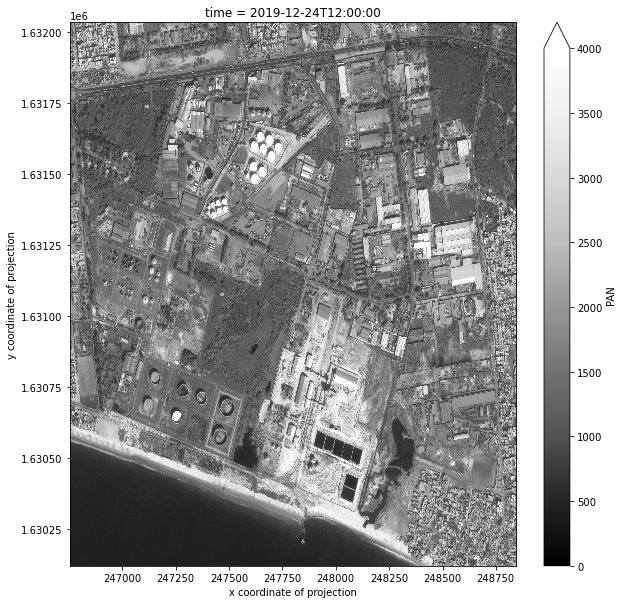

In [67]:
%%time
Pleiades_cube.PAN.isel(time=0).plot.imshow(cmap='Greys_r', vmin=0, vmax=4000, figsize=(10, 10))

## Extract a subset to work on a smaller region

If you would like to work on a subset, e.g. because the region of interest is smaller than the specified bounding box, you can use a WKT polygon or Shapefile to mask the region of interest. Please note however that the WKT / shapefile must be in the same coordinate reference system as the existing `xcube`.

Two methods of selection are possible:

- By masking - this keeps only the data of the WKT Polygon or shapefile

- By clipping - this creates a new bounding box, which ensures that the area of interest is within the subset but keeps the surrounding data.

In this example, we will mask our cube, using the geometry specified earlier.

In [68]:
# Mask the cube
Mbao_cube = mask_dataset_by_geometry(Pleiades_cube, geometry=mbao_geom.get_geojson())

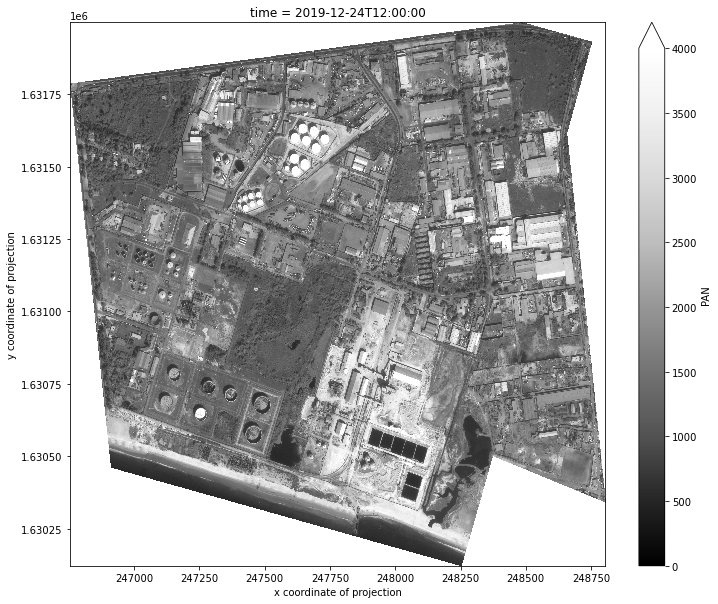

In [69]:
# Plot the masked cube
Mbao_cube.PAN.isel(time=0).plot.imshow(cmap='Greys_r', vmin=0, vmax=4000, figsize=(12, 10))

## Basic processing example: create a pan-sharpened RGB visualisation

The Red, Green and Blue bands of Pléiades have a resolution of 2m, whereas the panchromatic band has a resolution of 0.5m. By combining the bands, using a method called [pan-sharpening](https://www.geosage.com/highview/imagefusion.html), we can visualise a "sharpened" RGB True Color image at a resolution of 0.5 meters. 

Several methods can be used to pan-sharpen a Pléiades RGB image. In this example, we will use the Brovey algorithm (eq.2-3 in this [paper](http://jurnal.lapan.go.id/index.php/ijreses/article/view/2609)).

### Calculate pansharpened R, G, and B bands

In a first step we will calculate pan-sharpened bands for the Red, Green and Blue channels, using the panchromatic band as input. The bands will be stored in the cube for later re-use if needed. Note that the bands are not computed until use, meaning that this step is very fast.

In [70]:
Mbao_cube["PAN_RED"] = (Mbao_cube.B2 / (Mbao_cube.B0 + Mbao_cube.B1 + Mbao_cube.B2)) * Mbao_cube.PAN;
Mbao_cube["PAN_GREEN"] = (Mbao_cube.B1 / (Mbao_cube.B0 + Mbao_cube.B1 + Mbao_cube.B2)) * Mbao_cube.PAN
Mbao_cube["PAN_BLUE"] = (Mbao_cube.B0 / (Mbao_cube.B0 + Mbao_cube.B1 + Mbao_cube.B2)) * Mbao_cube.PAN

### Plot pan-sharpened RGB true color of Pléiades

In the following cell, the bands calculated above are used for the first time, and therefore only computed in this step. The first execution of this cell will be thus be slower than the previous steps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


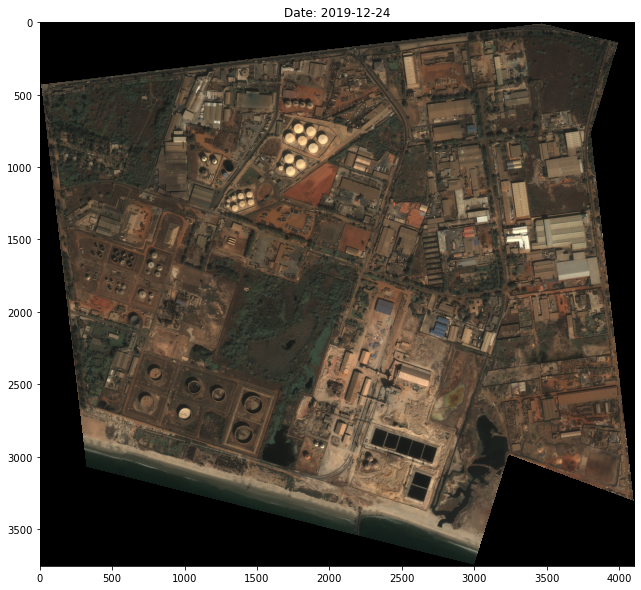

In [71]:
# Plot RGB images together
fig, ax = plt.subplots(1, figsize=(12,10))

# Build rgb combination and plot
rgb_tc = np.dstack((Mbao_cube.PAN_RED.isel(time=0), Mbao_cube.PAN_GREEN.isel(time=0), Mbao_cube.PAN_BLUE.isel(time=0)))
ax.imshow(rgb_tc / 2000)

# Set date as title
ax.set_title(f"Date: {str(Mbao_cube.time[0].data).split('T')[0]}")

plt.show()

### Now it's your turn...

With the examples provided above, you should have all the elements needed to access the data and start coding away. We look forward to your results!